# Marketing Email Campaign
## Goal
Optimizing marketing campaigns is one of the most common data science tasks.
Among the many possible marketing tools, one of the most efficient is usin􀁎 emails.
􀀬mails are great cause they are free and can be easily personalized. Email optimization
involves personalizing the text and/or the subject, who should receive it, when should be
sent, etc. Machine Learning excels at this.
## Challenge Description
The marketing team of an e-commerce site has launched an email campaign. This site has email
addresses from all the users who created an account in the past.
They have chosen a random sample of users and emailed them. The email let the user know
about a new feature implemented on the site. From the marketing team perspective, a success
is if the user clicks on the link inside of the email. This link takes the user to the company site.
## You are in charge of figuring out how the email campaign performed and were asked the following questions:
What percentage of users opened the email and what percentage clicked on the link
within the email?
The VP of marketing thinks that it is stupid to send emails to a random subset and in a
random way. Based on all the information you have about the emails that were sent, can
you build a model to optimize in future email campaigns to maximize the probability of
users clicking on the link inside the email?
By how much do you think your model would improve click through rate ( defined as # of
users who click on the link / total users who received the email). How would you test
that?
Did you find any interesting pattern on how the email campaign performed for different
segments of users? Explain.

In [90]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import plot_importance

In [39]:
email = pd.read_csv('email_table.csv')

In [40]:
email.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [41]:
email.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   email_id             100000 non-null  int64 
 1   email_text           100000 non-null  object
 2   email_version        100000 non-null  object
 3   hour                 100000 non-null  int64 
 4   weekday              100000 non-null  object
 5   user_country         100000 non-null  object
 6   user_past_purchases  100000 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 5.3+ MB


In [42]:
email.describe()

,email_id,hour,user_past_purchases
count,100000.000000,100000.000000,100000.00000
mean,498690.196160,9.059300,3.87845
std,289230.727534,4.439637,3.19611
min,8.000000,1.000000,0.00000
25%,246708.250000,6.000000,1.00000
50%,498447.000000,9.000000,3.00000
75%,749942.750000,12.000000,6.00000
max,999998.000000,24.000000,22.00000


In [43]:
email_opened = pd.read_csv('email_opened_table.csv')

In [44]:
email_opened.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [45]:
email_opened.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10345 entries, 0 to 10344
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  10345 non-null  int64
dtypes: int64(1)
memory usage: 80.9 KB


In [46]:
email_opened.describe()

,email_id
count,10345.000000
mean,499067.179604
std,289531.750750
min,49.000000
25%,247395.000000
50%,499261.000000
75%,752779.000000
max,999920.000000


In [47]:
link = pd.read_csv('link_clicked_table.csv')

In [48]:
link.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [49]:
link.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2119 entries, 0 to 2118
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   email_id  2119 non-null   int64
dtypes: int64(1)
memory usage: 16.7 KB


In [50]:
link.describe()

,email_id
count,2119.000000
mean,496335.084474
std,292863.020634
min,257.000000
25%,238548.500000
50%,488927.000000
75%,757207.000000
max,999920.000000


In [51]:
tables = {
    "email.csv": email,
    "email_opened.csv": email_opened,
    "link_clicked.csv": link
}
for name, df in tables.items():
    print(f"{name}:\t{df['email_id'].nunique()}")

email.csv:	100000
email_opened.csv:	10345
link_clicked.csv:	2119


## first question :
What percentage of users opened the email?
What percentage clicked the link inside the email?

In [52]:
email_opened = email_opened.assign(opened=1)
link = link.assign(clicked=1)
data = (
    email
    .merge(email_opened[['email_id', 'opened']], on='email_id', how='left')
    .merge(link[['email_id', 'clicked']], on='email_id', how='left')
    .fillna(0)
    .astype({'opened': int, 'clicked': int})
)

In [53]:
data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [54]:
total_emails = len(data)
total_opened = data['opened'].sum()
total_clicked = data['clicked'].sum()

In [55]:
open_rate = total_opened / total_emails * 100
click_through_rate = total_clicked / total_emails * 100
click_to_open_rate = total_clicked / total_opened * 100 if total_opened > 0 else 0

In [56]:
print("Open Rate:", round(open_rate, 2), "%")
print("Click-Through Rate:", round(click_through_rate, 2), "%")
print("Click-to-Open Rate:", round(click_to_open_rate, 2), "%")

Open Rate: 10.34 %
Click-Through Rate: 2.12 %
Click-to-Open Rate: 20.48 %


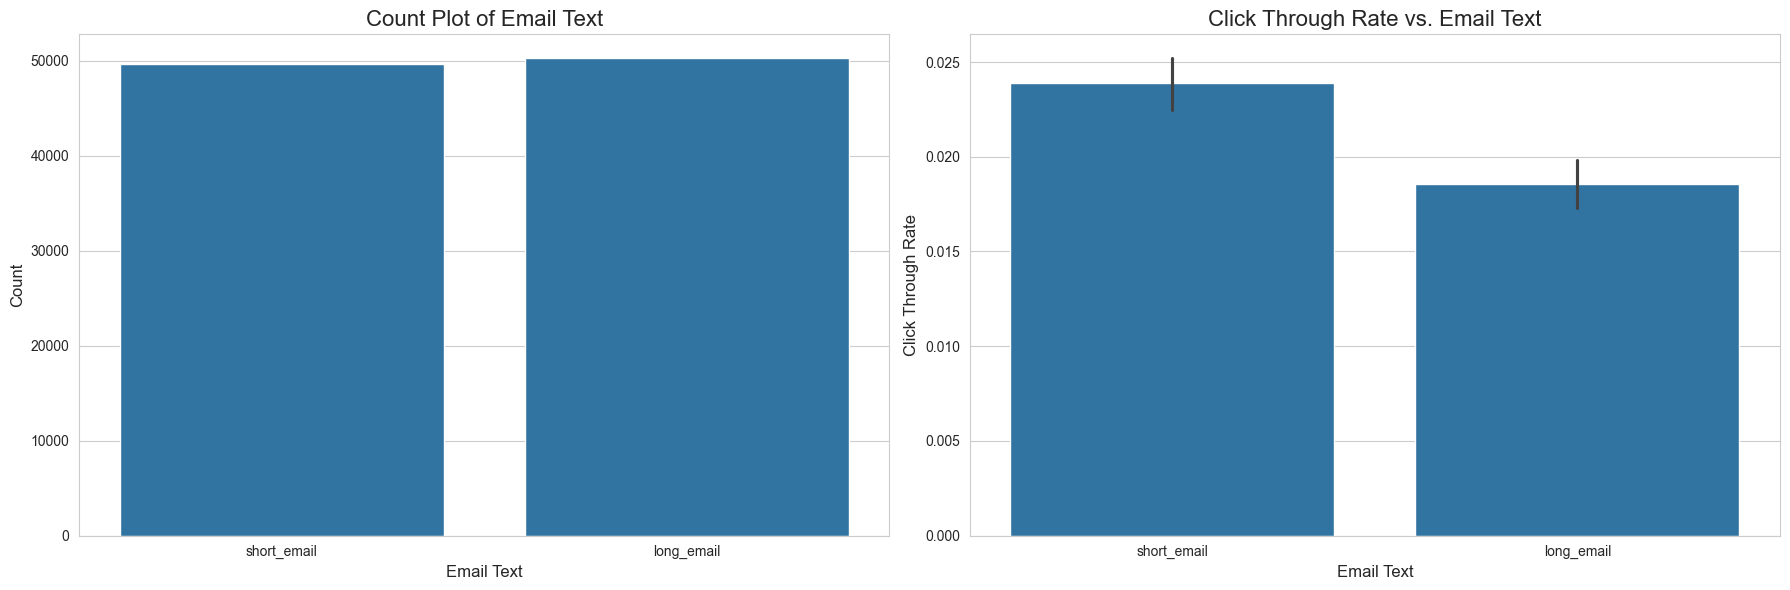

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='email_text', data=data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)
sns.barplot(x='email_text', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

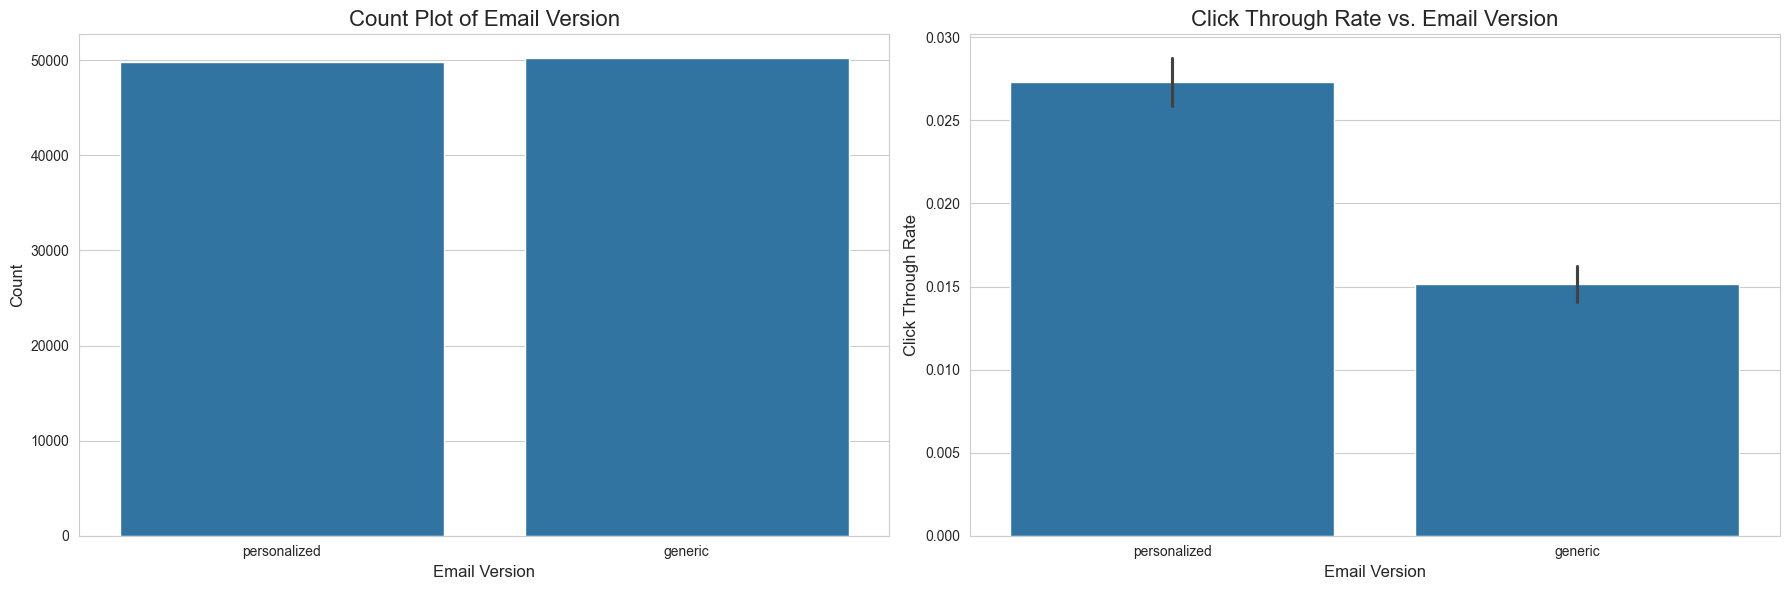

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='email_version', data=data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)
sns.barplot(x='email_version', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

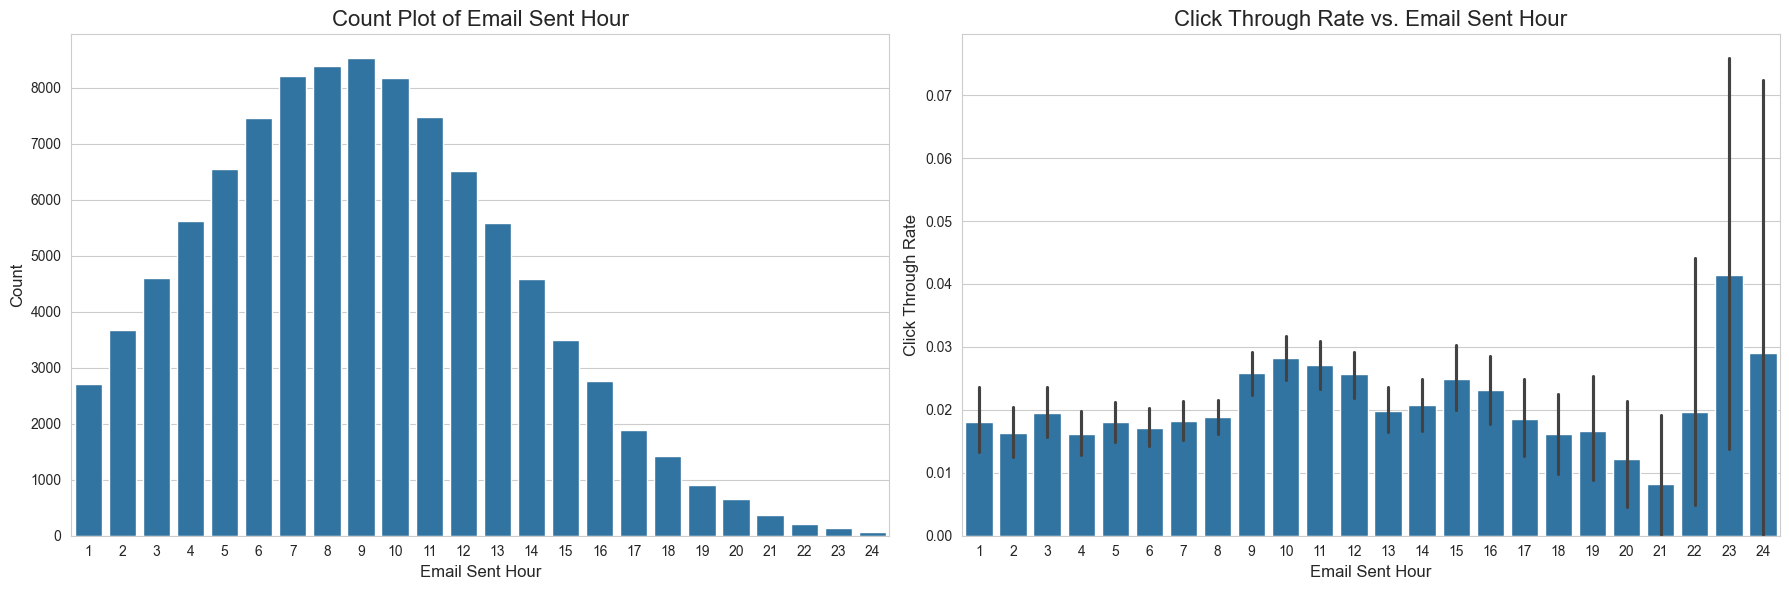

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='hour', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)
sns.barplot(x='hour', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

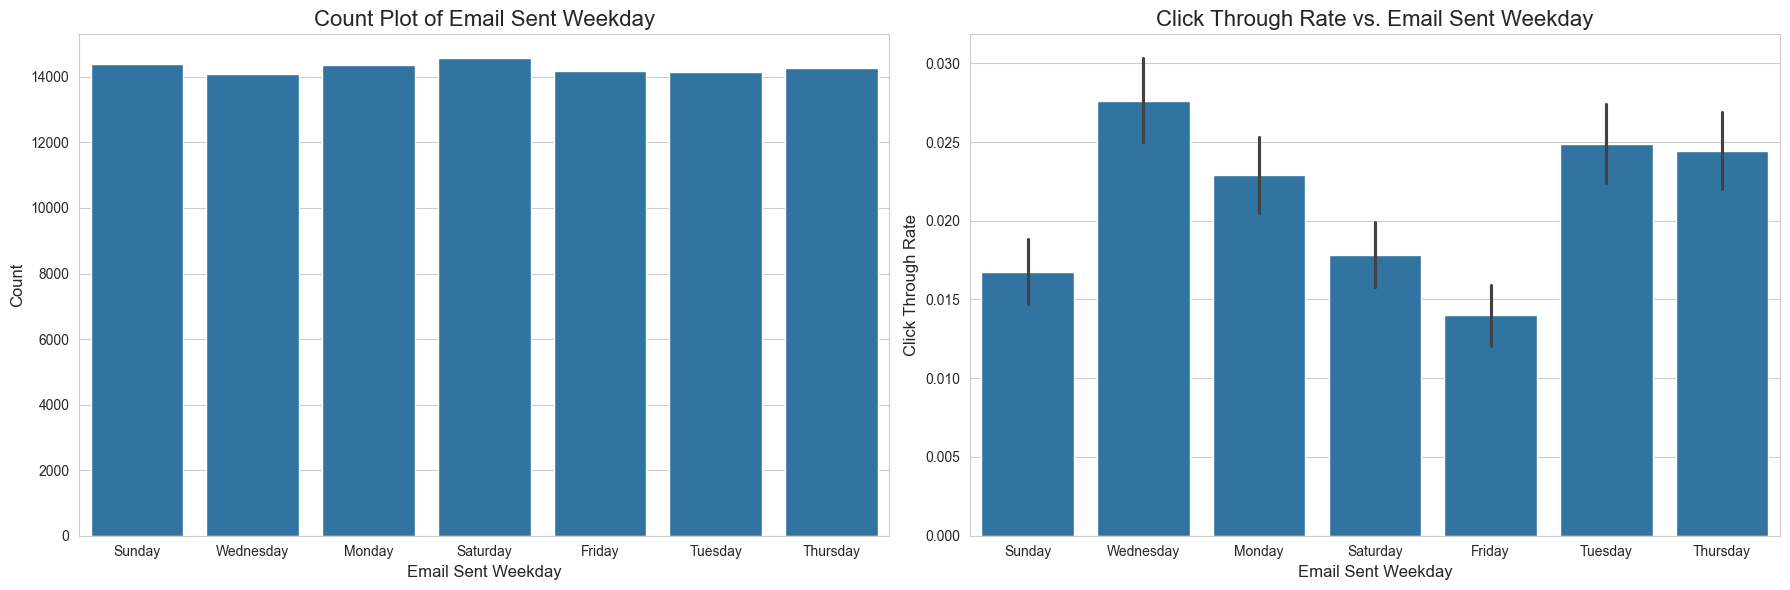

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)
sns.barplot(x='weekday', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

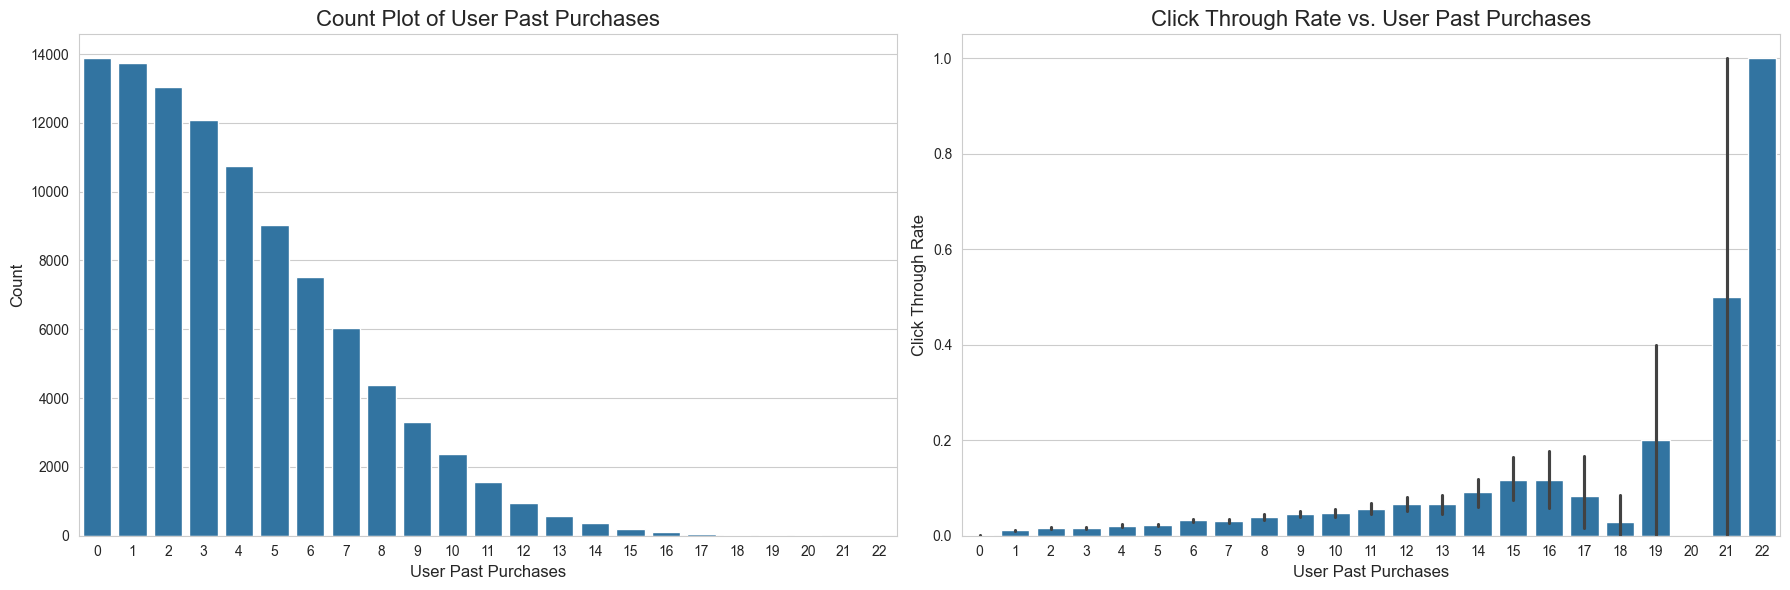

In [61]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
sns.countplot(x='user_past_purchases', data=data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)
sns.barplot(x='user_past_purchases', y='clicked', data=data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

In [62]:
# Binary features
data['email_text'] = data['email_text'].map({'long_email':0, 'short_email':1})

In [63]:
data['email_version'] = data['email_version'].map({'generic':0, 'personalized':1})

In [64]:
data = pd.get_dummies(data, columns=['weekday', 'user_country'], drop_first=False).astype(int)

In [65]:
data.head()

,email_id,email_text,email_version,hour,user_past_purchases,opened,clicked,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,user_country_ES,user_country_FR,user_country_UK,user_country_US
0,85120,1,1,2,5,0,0,0,0,0,1,0,0,0,0,0,0,1
1,966622,0,1,12,2,1,1,0,0,0,1,0,0,0,0,0,1,0
2,777221,0,1,11,2,0,0,0,0,0,0,0,0,1,0,0,0,1
3,493711,1,0,6,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,106887,0,0,14,6,0,0,0,1,0,0,0,0,0,0,0,0,1


In [66]:
X = data.drop(columns=['email_id', 'clicked'])
y = data['clicked']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [70]:
y_train.value_counts()

clicked
0    78305
1     1695
Name: count, dtype: int64

In [72]:
smote = SMOTE(random_state=42)

In [73]:
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [77]:
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss')

In [78]:
model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [79]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

In [80]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     19576
           1       0.22      0.91      0.36       424

    accuracy                           0.93     20000
   macro avg       0.61      0.92      0.66     20000
weighted avg       0.98      0.93      0.95     20000



In [81]:
cm = confusion_matrix(y_test, y_pred)

In [82]:
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[18219  1357]
 [   39   385]]


In [83]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", round(roc_auc, 4))

ROC-AUC Score: 0.9612


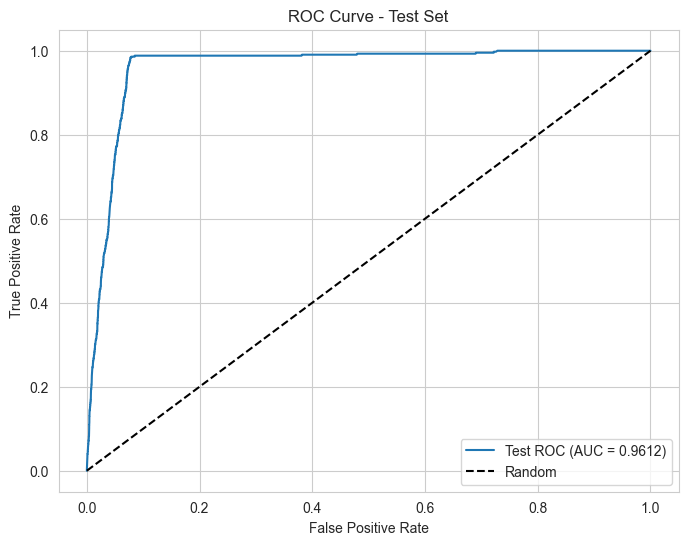

In [84]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Test ROC (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend()
plt.show()

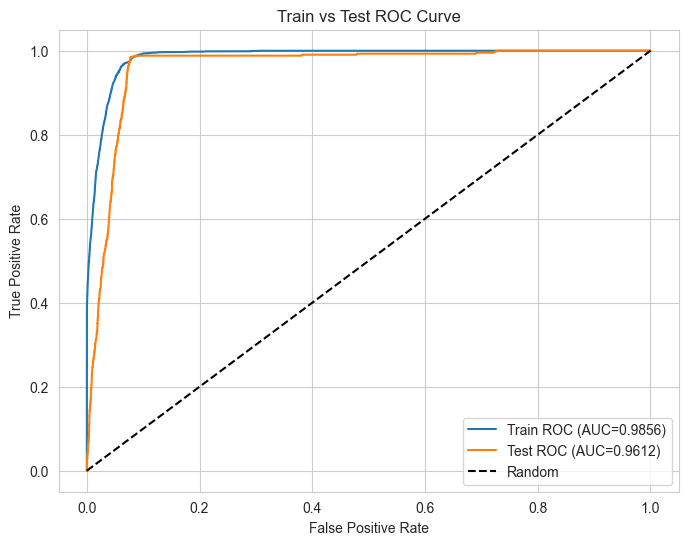

In [85]:
y_train_pred_proba = model.predict_proba(X_train_res)[:,1]
fpr_train, tpr_train, _ = roc_curve(y_train_res, y_train_pred_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC={roc_auc_score(y_train_res, y_train_pred_proba):.4f})')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC={roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0,1],[0,1],'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train vs Test ROC Curve')
plt.legend()
plt.show()

In [86]:
importance = model.get_booster().get_score(importance_type='gain')

In [87]:
importance = dict(sorted(importance.items(), key=lambda item: item[1], reverse=True))

In [88]:
print(importance)

{'opened': 4025.361328125, 'user_country_UK': 182.71302795410156, 'weekday_Tuesday': 92.36076354980469, 'weekday_Wednesday': 84.74011993408203, 'weekday_Monday': 75.24374389648438, 'weekday_Sunday': 62.944374084472656, 'weekday_Saturday': 61.583316802978516, 'user_country_FR': 58.97172164916992, 'weekday_Thursday': 58.09978103637695, 'weekday_Friday': 53.7363166809082, 'user_country_ES': 46.131431579589844, 'user_past_purchases': 41.907493591308594, 'email_text': 33.920265197753906, 'user_country_US': 33.201786041259766, 'hour': 26.608434677124023, 'email_version': 24.99160385131836}


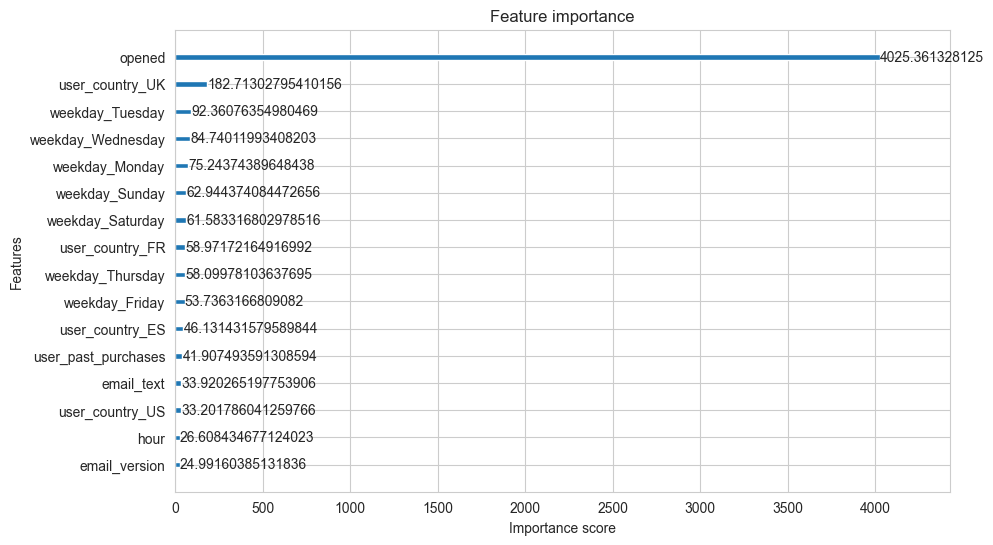

In [91]:
plot_importance(model, importance_type='gain')
plt.show()